In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('parkinsons.csv', delimiter=',')

In [20]:
import timeit
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
t0 = timeit.default_timer()

# We use SAGA solver
solver = 'saga'

# Turn down for faster run time
n_samples = 195

# Memorized fetch_rcv1 for faster access
# X = data.drop(columns=['name', 'status']).to_numpy() -> 75.38%
y = data['status'].to_numpy()

# X = data[['HNR','RPDE','DFA','PPE']].to_numpy() -> 75.38%

X = data[['MDVP:Jitter(Abs)','MDVP:RAP','MDVP:PPQ','Jitter:DDP']].to_numpy()

Dataset parkinsons, train_samples=130, n_features=4, n_classes=2
[model=One versus Rest, solver=saga] Number of epochs: 1
[model=One versus Rest, solver=saga] Number of epochs: 2
[model=One versus Rest, solver=saga] Number of epochs: 20
Test accuracy for model ovr: 0.7538
% non-zero coefficients for model ovr, per class:
 [0.]
Run time (20 epochs) for model ovr:0.01
[model=Multinomial, solver=saga] Number of epochs: 1
[model=Multinomial, solver=saga] Number of epochs: 3
[model=Multinomial, solver=saga] Number of epochs: 7
Test accuracy for model multinomial: 0.7538
% non-zero coefficients for model multinomial, per class:
 [0.]
Run time (7 epochs) for model multinomial:0.01
Example run in 2.763 s


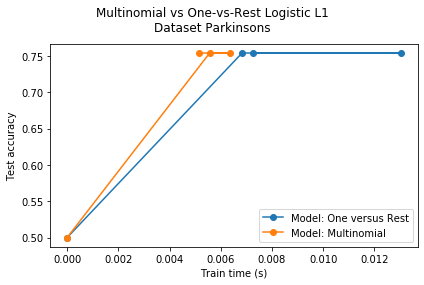

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    stratify=y,
                                                    test_size=0.33)
train_samples, n_features = X_train.shape
n_classes = np.unique(y).shape[0]

print('Dataset parkinsons, train_samples=%i, n_features=%i, n_classes=%i'
      % (train_samples, n_features, n_classes))

models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 2, 20]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7]}}

for model in models:
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] Number of epochs: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                penalty='l1',
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = timeit.default_timer()
        lr.fit(X_train, y_train)
        train_time = timeit.default_timer() - t1

        y_pred = lr.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        accuracies.append(accuracy)
        densities.append(density)
        times.append(train_time)
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['accuracies'] = accuracies
    print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))
    print('%% non-zero coefficients for model %s, '
          'per class:\n %s' % (model, densities[-1]))
    print('Run time (%i epochs) for model %s:'
          '%.2f' % (model_params['iters'][-1], model, times[-1]))

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['accuracies']
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % 'Parkinsons')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = timeit.default_timer() - t0
print('Example run in %.3f s' % run_time)
plt.show()